5
7
9
5
7
9


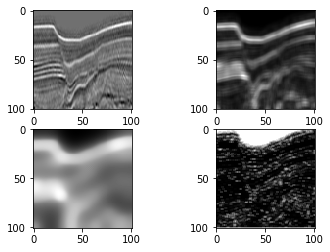

5.122096461411772 0.038015551591531416 1.0 0.0001638428833754856 0.0


In [49]:
import os
import numpy as np
import cv2
from scipy.interpolate import RectBivariateSpline
from skimage.filters import apply_hysteresis_threshold
import imagehelper
import matplotlib.pyplot as plt
import glob, os
import covariance_real
import edge_real
import gl_real
import smootheness_real
def get_image_files():
    return glob.glob(os.path.join("data/original", '6.png'))

# See PyCharm help at https://www.jetbrains.com/help/pycharm/
def show_in_plot(img1, img2, img3, img4):
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.subplot(2, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.subplot(2, 2, 3)
    plt.imshow(img3, cmap='gray')
    plt.subplot(2, 2, 4)
    plt.imshow(img4, cmap='gray')
    plt.show()

def get_patch_at(pixel_grid, i, j, size):
    x_length, y_length = pixel_grid.shape
    half_size = int(size / 2)
    start_x: int = max(0, i - half_size)
    end_x: int = min(x_length, i + half_size + 1)
    start_y: int = max(0, j - half_size)
    end_y: int = min(y_length, j + half_size + 1)
    pad_start_x: int = max(0, -(i - half_size))
    pad_end_x: int = max(0, (i + half_size + 1) - x_length)
    pad_start_y: int = max(0, -(j - half_size))
    pad_end_y: int = max(0, (j + half_size + 1) - y_length)
    pad_value = ((pad_start_x, pad_end_x), (pad_start_y, pad_end_y))
    sliced = pixel_grid[start_x:end_x, start_y:end_y]
    if pad_start_x == 0 and pad_end_x == 0 and pad_start_y == 0 and pad_end_y == 0:
        return sliced
    else:
        return np.pad(sliced, pad_value, 'edge')



def get_cov(x, y, patch_size):
    x_avg = np.average(x)
    y_avg = np.average(y)
    sum = np.multiply(x-x_avg, y-y_avg)
    return np.sum(sum) / patch_size * patch_size

def treat(img_path):
    I = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
    #I = cv2.resize(I, dsize=(200, 200), interpolation=cv2.INTER_AREA)
    I = I / 255

    chaos=covariance_real.treat_covariance_with_multple_window(img_path)
    edge=edge_real.treat_edge_with_multple_window(img_path)
    GLCM=gl_real.treat_glcm(img_path,3,'homogeneity')
    sm=smootheness_real.treat_result(img_path,3,5)
    # show_in_plot(covxx)
    show_in_plot(I, sm, edge,GLCM)
    print(np.max(edge),np.min(edge),np.max(GLCM),np.min(GLCM),np.min(sm))
    # show_in_plot(covyy)
images_path = get_image_files()
for image in images_path:
    treat(image)